# Analysis for ORLR workshop, NeurIPS 2020

In [183]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import scipy.spatial.distance as distance
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring
import random

### Load dataframes

In [11]:
#read in dataframes from each eventType
df_block = pd.read_csv('../results/csv/df_block.csv')
df_chat = pd.read_csv('../results/csv/df_chat.csv')
df_exit = pd.read_csv('../results/csv/df_exit.csv')
df_trial = pd.read_csv('../results/csv/df_trial.csv')

### Apply exclusion criteria

In [12]:
# How many dyads fulfill 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

#delete rows that aren't greater than 75% in 9 trials
df75 = df75[df75['trials']>=9]

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 49


In [13]:
includedGames = list(df75.reset_index().gameid)

In [14]:
# Exclude from analysis
df_block = df_block[df_block.gameid.isin(includedGames)]
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_exit = df_exit[df_exit.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

## Task performance

### Accuracy

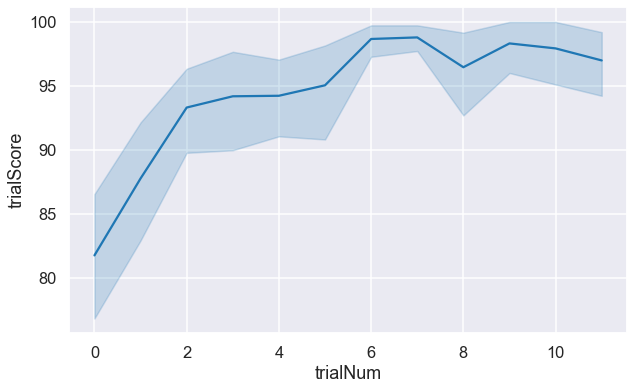

In [15]:
# accuracy across trials
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='x')
# sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='trialScore', hue='gameid')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

### Timing

In [ ]:
# # Wrangle timing dataframes

# # Find the latest time that a block was placed in each trial.
# # This signifies the end of a trial (i.e. upper bound on total trial time)
# df_trial_time = df_block[~df_block.practice].groupby(['gameid','trialNum'])\
#                 ['timeElapsedInTrial'].max().reset_index()
# df_trial_time = df_trial_time.rename(columns = {'timeElapsedInTrial':'time_final_block'})

# # Grab the duration of the Architect's turn
# chat_times = df_chat[~df_chat.practice].groupby(['gameid','trialNum'])\
# ['timeElapsedInTurn'].sum().reset_index()

# # total time to place blocks (by taking summing maximum block placement time for each turn)
# total_block_times = df_block[(~df_block.practice)].groupby(['gameid','trialNum','turnNum'])\
#                     ['timeElapsedInTurn'].max()\
#                     .groupby(['gameid','trialNum']).sum().reset_index()

# # # time from trial_start to final block placed in turn, summed across the trial
# df_trial_time['total_block_duration'] = total_block_times['timeElapsedInTurn'] 

# # time from trial_start to chat message sent, summed across the trial
# df_trial_time['total_chat_duration'] = chat_times['timeElapsedInTurn']

# # # sum of block placement and chat time in a trial
# df_trial_time['total_duration'] = df_trial_time['total_chat_duration'] + df_trial_time['total_block_duration']

# # # differnce between final block placement time and total chat plus block placement time.
# # # i.e. the total extra time in a trial, mainly consisting of time to press done button
# df_trial_time['diff'] = df_trial_time['time_final_block'] - df_trial_time['total_duration']

# # in addition, add a total_turn_duration- 
# #  the time between this turn start and the next turn start (or final block placement)
# #  as an estimate for when the Done button is pressed.
# # didn't have the data for this in pilot3- we are now saving turnStartTime

# # re-add trial info to trial df
# df_trial = df_trial.merge(df_trial_time, how='left', on=['gameid','trialNum'])

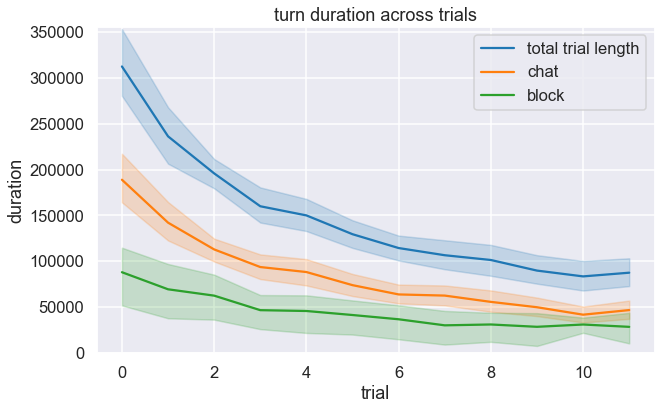

In [7]:
# total trial time across trials

g = plt.figure(figsize=(10,6))
ax1 = sns.lineplot(data=df_trial, x='trialNum', y='time_final_block', label='total trial length')
ax2 = sns.lineplot(data=df_trial, x='trialNum', y='total_chat_duration', label='chat')
ax3 = sns.lineplot(data=df_trial, x='trialNum', y='total_block_duration', label='block')

plt.ylabel('duration')
plt.xlabel('trial')
plt.ylim((0,355000))
plt.title('turn duration across trials')
plt.legend()

Text(0.5, 1.0, 'trial duration (final block placement time) across trials')

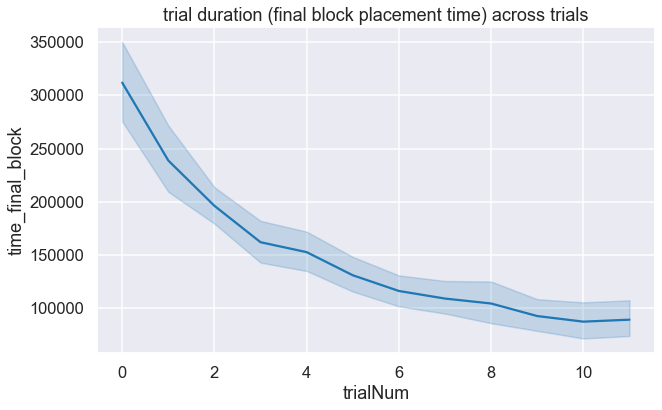

In [8]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='time_final_block')
# plt.ylim((0,350000))
plt.title('trial duration (final block placement time) across trials')

Text(0.5, 1.0, 'total chat duration across trials')

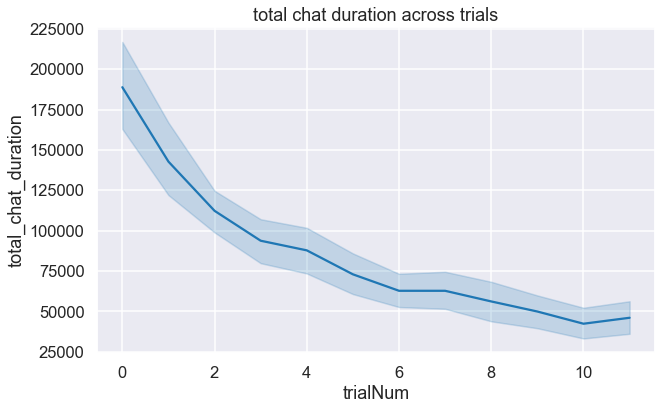

In [9]:
# total chat duration (architect turn-time) across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='total_chat_duration')
# plt.ylim((0,350000))
plt.title('total chat duration across trials')

Text(0.5, 1.0, 'total block duration across trials')

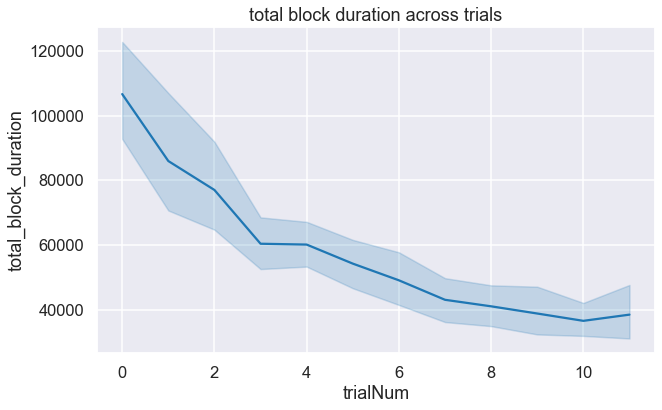

In [10]:
# total block placement duration (builder turn-time, not inluding no-block turns), across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='total_block_duration')
# plt.ylim((0,350000))
plt.title('total block duration across trials')

Text(0.5, 1.0, 'difference between total block time and final block times')

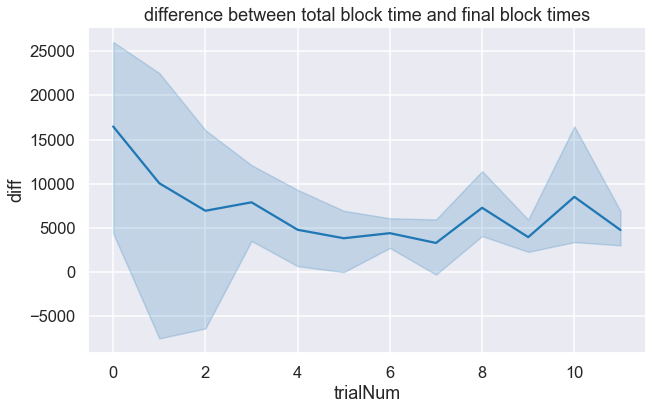

In [11]:
# total block placement duration (builder turn-time, not inluding no-block turns), across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='diff')
# plt.ylim((0,350000))
plt.title('difference between total block time and final block times')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

## NLP

### Efficiency of instructions

#### Across trials

Text(0.5, 1.0, 'total words across trials')

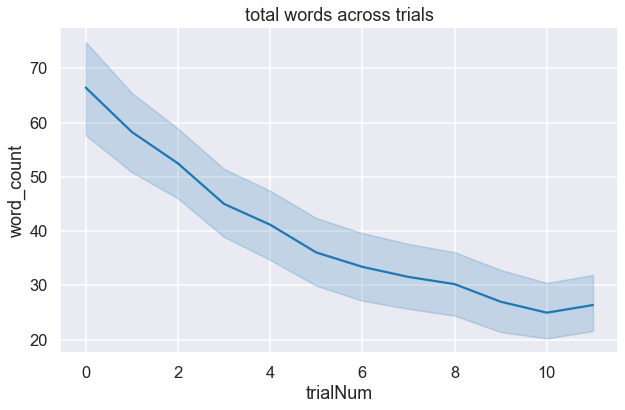

In [29]:
# word count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='word_count')
#              , hue='gameid')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total words across trials')

Text(0.5, 1.0, 'total characters across trials')

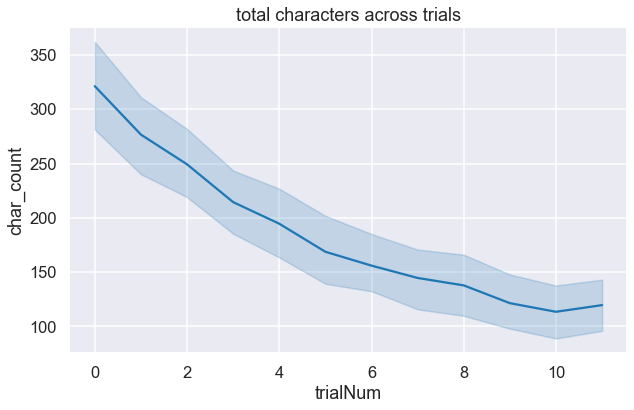

In [31]:
# char count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='char_count')
             #, hue='gameid')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total characters across trials')

#### Across repetitions of scenes (sides of towers can switch)

In [8]:
rep_sums = df_chat[~df_chat.practice].groupby(['gameid','repNum']).sum().reset_index()
trial_counts = df_chat.groupby(['gameid','trialNum']).count().reset_index()

Text(0.5, 1.0, 'total words across reps')

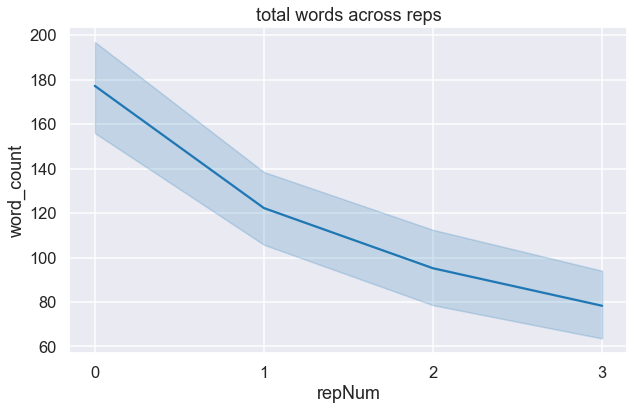

In [9]:
# word count across reps

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums, x='repNum',y='word_count')
plt.title('total words across reps')

Text(0.5, 1.0, 'total characters across reps')

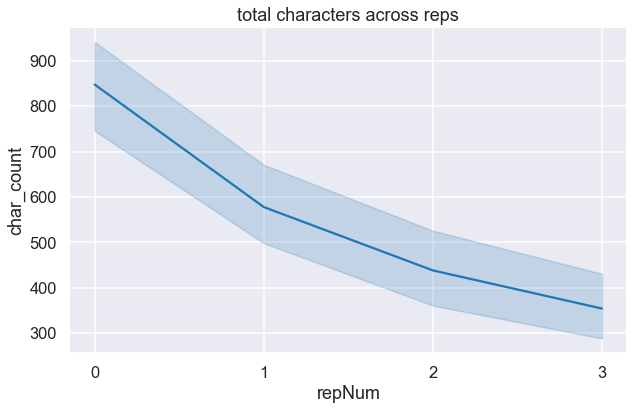

In [10]:
# char count across reps

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums, x='repNum',y='char_count')
plt.title('total characters across reps')

### Conventions

### Compositional abstractions

#### 3.5: Convergence/ divergence analysis

Use function that takes a distance matrix and return a variance. 
Wasserstein distance between every pair WITHIN a rep
Take a random 49 participants to get a new distance matrix. (Do this 1000 times for 95% CIs)
Stat: how many had a difference in the opposite direction.
Error bars: 1.96\*SE of resample distribution (1000)

We talked about doing ‘Jackknife’ resampling (deterministic leave-one-out for all ppts, for every sample find difference- difference distribution.) plus adjusting for smaller sample size

The point of this analysis is to show that people end up using more similar words to each other than they start with. I'm currently concerned that if all people use fewer words at the end, then it might reduce the distance between them all.


In [445]:
df_refexp_unprocessed = pd.read_csv('../results/csv/JJ_content.csv')
df_refexp_unprocessed

,gameid,leftTarget,rightTarget,trialNum,turnNum,repNum,message,# @ block-level,# @ tower-level,# @ scene-level,phrases,phrases.1,content
0,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,4,0,Now place a blue block on top of that that lin...,1,0,0,a blue block,a blue block,a blue block a blue block
1,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,6,0,"remove that last blue block, place it on top o...",1,0,0,that last blue block,last blue block,that last blue block last blue block
2,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,8,0,place a red block on the second grid from the ...,1,0,0,a red block,a red block,a red block a red block
3,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,10,0,now place another red block three more space t...,1,0,0,another red block,another red block,another red block another red block
4,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,C,Pi,0,12,0,place two blue blocks next to each other conne...,2,0,0,two blue blocks,two blue blocks,two blue blocks two blue blocks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,C,Pi,7,0,2,"left- very tall skinny C, right - arch",0,2,0,"very tall skinny C, arch","very tall skinny C, arch","very tall skinny C, arch very tall skinny C, arch"
2136,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,L,C,8,0,2,"left- large L, right - very tall skinny C",0,2,0,"large L, very tall skinny C","large L, very tall skinny C","large L, very tall skinny C large L, very tall..."
2137,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,Pi,C,9,0,3,"left- arch, right - very tall skinny C",0,2,0,"arch, very tall skinny C","arch, very tall skinny C","arch, very tall skinny C arch, very tall skinny C"
2138,5156-be8ae9d7-0f4f-4f69-9d5b-fa70394f9dea,Pi,L,10,0,3,"you are rockin this! Left- arch, right- large L",0,2,0,"arch, large L","arch, large L","arch, large L arch, large L"


In [459]:
df_refexp_unprocessed = pd.read_csv('../results/csv/JJ_content.csv')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.lower()
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r'~', '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r'\(', '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r'\)', '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r'\,', '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r"\'", '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r"\:", '')
df_refexp_unprocessed['content'] = df_refexp_unprocessed['content'].str.replace(r"\;", '')

In [460]:
# Get word frequency distributions for all ppts
df_refexp = df_refexp_unprocessed.groupby(['gameid','repNum'])['content'].apply(lambda x: ' '.join(x)).reset_index()
df_refexp['word_freq'] = df_refexp['content'].apply(lambda x: Counter(x.split()))
df_refexp.head()

,gameid,repNum,content,word_freq
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,two blue blocks two blue two red block two red...,"{'two': 15, 'blue': 17, 'blocks': 4, 'red': 15..."
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,same exact construction the same exact constru...,"{'same': 2, 'exact': 2, 'construction': 2, 'th..."
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,two blue blocks two blue two red blocks two re...,"{'two': 14, 'blue': 16, 'blocks': 4, 'red': 11..."
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,3,one blue block two red blue two red one blue b...,"{'one': 9, 'blue': 16, 'block': 8, 'two': 10, ..."
4,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,0,blue blue blue blue blue blue red red red red ...,"{'blue': 22, 'red': 24, 'another': 1, 'last': ..."


In [461]:
# create support
split_words = df_refexp['content'].apply(lambda x: x.split())
all_words = list(pd.Series([st for row in split_words for st in row]).unique())
support = {}
for word in all_words:
    support[word] = 0.0
    
def get_pdist(row):
    num_words = np.sum(list(row['word_freq'].values()))
    pdist = support.copy()
    for i, (word, count) in enumerate(row['word_freq'].items()):
        pdist[word] = count/num_words
    return pdist

In [462]:
def jsdiv(P, Q):
    """Compute the Jensen-Shannon divergence between two probability distributions.

    Input
    -----
    P, Q : array-like
        Probability distributions of equal length that sum to 1
    """

    def _kldiv(A, B):
        return np.sum([v for v in A * np.log2(A/B) if not np.isnan(v)])

    P = np.array(P)
    Q = np.array(Q)

    M = 0.5 * (P + Q)

    return 0.5 * (_kldiv(P, M) +_kldiv(Q, M))

In [463]:
df_refexp['word_pdist'] = df_refexp.apply(get_pdist, axis = 1)
df_refexp['word_pdist_numeric'] = df_refexp['word_pdist'].apply(lambda dist: list(dist.values()))

In [469]:
# Take Wasserstein distance between every pair within each rep (save to table)

reps = [0,3]
dyads = list(df_refexp['gameid'].unique())

empirical_distances = np.zeros((len(reps),len(dyads),len(dyads)))

for r, rep in enumerate(reps):
    for i, dyad_i in enumerate(dyads):
        dyad_i_pdist = df_refexp[(df_refexp.repNum==rep) & (df_refexp.gameid==dyad_i)]['word_pdist_numeric'].iloc[0]
        for j, dyad_j in enumerate(dyads):
            dyad_j_pdist = df_refexp[(df_refexp.repNum==rep) & (df_refexp.gameid==dyad_j)]['word_pdist_numeric'].iloc[0]
            empirical_distances[r,i,j] = jsdiv(dyad_i_pdist, dyad_j_pdist)

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()
/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


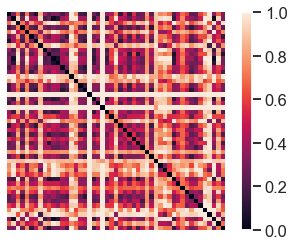

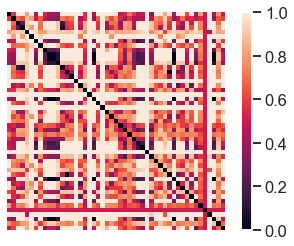

In [470]:
fig, ax = plt.subplots()
ax.axis('off')
im = ax.imshow(empirical_distances[0])
fig.colorbar(im)

fig, ax = plt.subplots()
ax.axis('off')
im = ax.imshow(empirical_distances[1])
fig.colorbar(im)

In [420]:
dyad_num = 35
df_refexp[(df_refexp.repNum==0) & (df_refexp.gameid==dyads[dyad_num])]['word_pdist']

stds = {}

for r in [0,3]:
    stds[r] = {}
    w_probs = {}

    for w in all_words:
        w_probs[w] = list(df_refexp[(df_refexp.repNum==r)]['word_pdist'].apply(lambda probs: probs[w]))

    for w in all_words:    
        stds[r][w] = np.std(w_probs[w])
        
    stds[r] = {k: v for k, v in sorted(stds[r].items(), key=lambda item: item[1])}

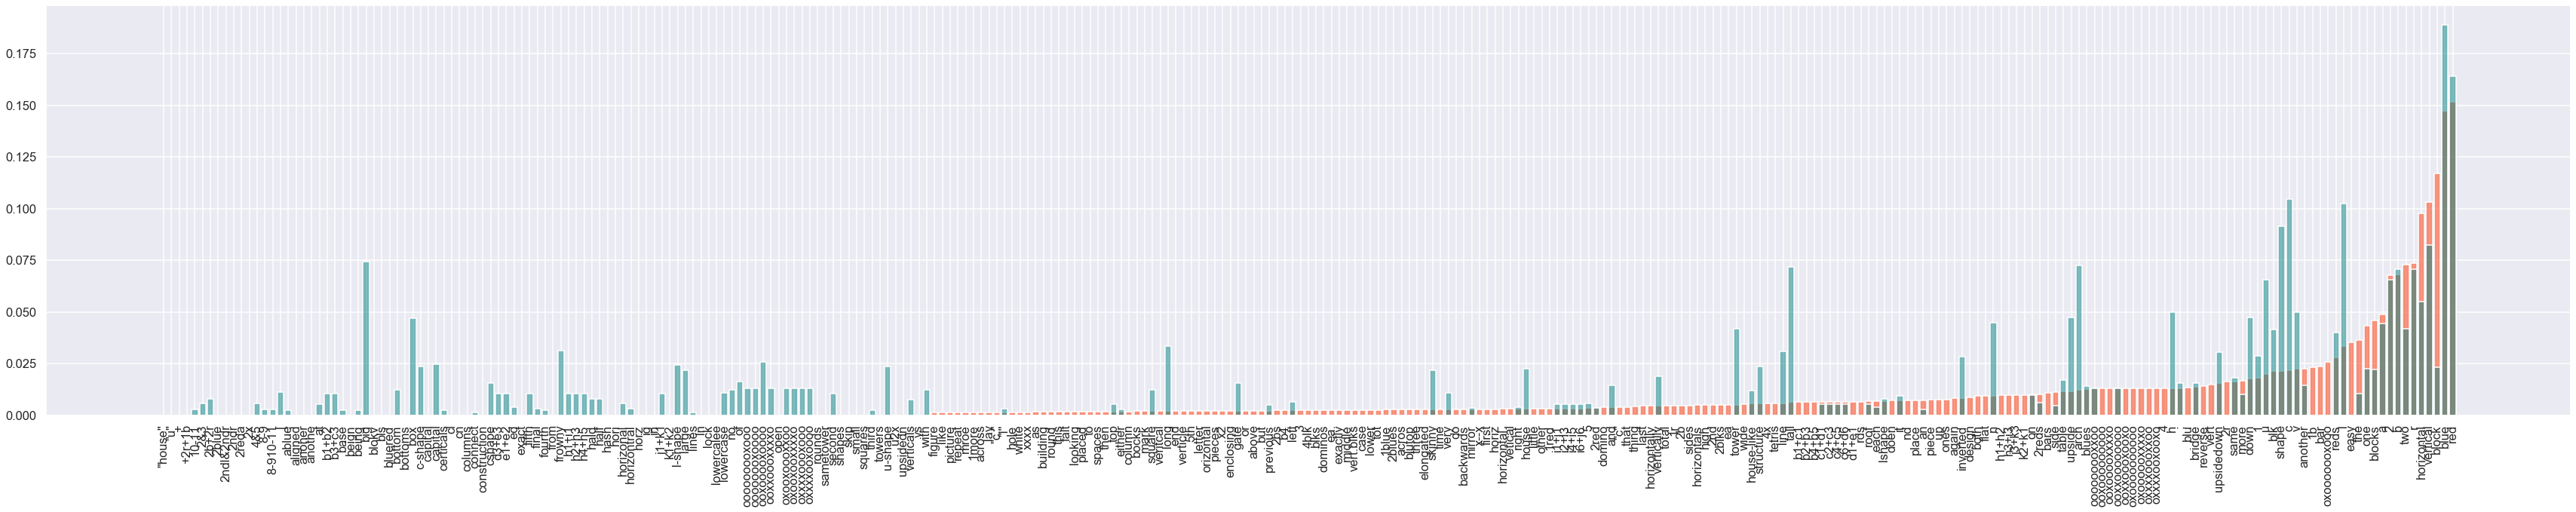

In [439]:
fig = plt.figure(figsize=(60,10))
ax = fig.add_subplot(111)
ax.bar(x = list(stds[0].keys()), height= stds[0].values(), fc=(1, 0.2, 0, 0.5))
ax.bar(x = list(stds[0].keys()), height= [stds[3][w] for w in list(stds[0].keys())], fc=(0, 0.5, 0.5, 0.5))
_ = plt.xticks(rotation='vertical')
plt.savefig('words.pdf')

<BarContainer object of 14 artists>

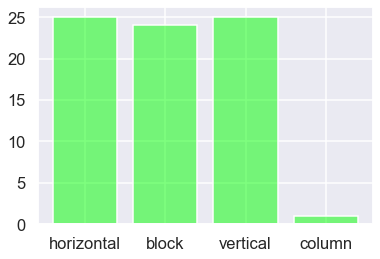

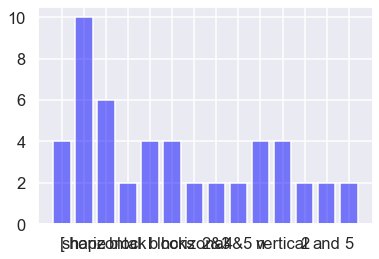

In [352]:
fig = plt.figure()
ax = fig.add_subplot(111)
dyad_num = 35

counts = df_refexp[(df_refexp.repNum==0) & (df_refexp.gameid==dyads[dyad_num])]['word_freq'].iloc[0]
ax.bar(x = list(counts.keys()), height= list(counts.values()), fc=(0, 1, 0, 0.5))

fig = plt.figure()
ax = fig.add_subplot(111)

counts = df_refexp[(df_refexp.repNum==3) & (df_refexp.gameid==dyads[dyad_num])]['word_freq'].iloc[0]
ax.bar(x = list(counts.keys()), height= list(counts.values()), fc=(0, 0, 1, 0.5))

variability across dyads for each word
How different are different dyads

In [353]:
df_refexp

,gameid,repNum,content,word_freq,word_pdist,word_pdist_numeric
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,two blue blocks two blue two red block two red...,"{'two': 15, 'blue': 17, 'blocks': 4, 'red': 15...","{'two': 0.22727272727272727, 'blue': 0.2575757...","[0.22727272727272727, 0.25757575757575757, 0.0..."
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,same exact construction the same exact constru...,"{'same': 2, 'exact': 2, 'construction': 2, 'th...","{'two': 0.15384615384615385, 'blue': 0.1794871...","[0.15384615384615385, 0.1794871794871795, 0.07..."
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,two blue blocks two blue two red blocks two re...,"{'two': 14, 'blue': 16, 'blocks': 4, 'red': 11...","{'two': 0.1917808219178082, 'blue': 0.21917808...","[0.1917808219178082, 0.2191780821917808, 0.054..."
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,3,one blue block two red blue two red one blue b...,"{'one': 9, 'blue': 16, 'block': 8, 'two': 10, ...","{'two': 0.1388888888888889, 'blue': 0.22222222...","[0.1388888888888889, 0.2222222222222222, 0.055..."
4,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,0,blue blue blue blue blue blue red red red red ...,"{'blue': 22, 'red': 24, 'another': 1, 'last': ...","{'two': 0.0, 'blue': 0.44, 'blocks': 0.02, 're...","[0.0, 0.44, 0.02, 0.48, 0.0, 0.0, 0.0, 0.0, 0...."
...,...,...,...,...,...,...
191,9727-37a58c13-7178-412c-88d0-6b8841439106,3,another house shape certicals second and fifth...,"{'another': 1, 'house': 4, 'shape': 3, 'certic...","{'two': 0.03636363636363636, 'blue': 0.0363636...","[0.03636363636363636, 0.03636363636363636, 0.0..."
192,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,0,a blue block blue a blue block blue a red bloc...,"{'a': 21, 'blue': 24, 'block': 24, 'red': 24, ...","{'two': 0.0, 'blue': 0.25, 'blocks': 0.0, 'red...","[0.0, 0.25, 0.0, 0.25, 0.25, 0.0, 0.0, 0.0, 0...."
193,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,1,a red block red a red block red blue blocks bl...,"{'a': 10, 'red': 16, 'block': 13, 'blue': 18, ...","{'two': 0.125, 'blue': 0.225, 'blocks': 0.1125...","[0.125, 0.225, 0.1125, 0.2, 0.1625, 0.0, 0.0, ..."
194,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,a blue block blue another blue block blue two ...,"{'a': 7, 'blue': 18, 'block': 7, 'another': 2,...","{'two': 0.17391304347826086, 'blue': 0.2608695...","[0.17391304347826086, 0.2608695652173913, 0.04..."


In [355]:
word_pdist

NameError: name 'word_pdist' is not defined

In [180]:
n = df_refexp['gameid'].nunique()
n_indices = np.array(range(0,n))
ppts = df_refexp['gameid'].unique()

rep2_ppts = n_indices.sample(n=n, random_state=seed, replace=True)
rep2_ppts

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

(array([  2.,  15.,  32., 113., 255., 271., 188.,  92.,  27.,   5.]),
 array([-0.01109958,  0.00577775,  0.02265508,  0.03953242,  0.05640975,
         0.07328708,  0.09016441,  0.10704175,  0.12391908,  0.14079641,
         0.15767375]),
 <a list of 10 Patch objects>)

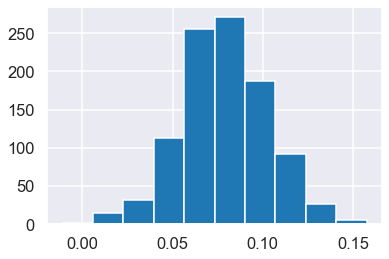

In [232]:
# Bootstrap sample 49 ppts and get values from above dataframe to create a new distance matrix

n = df_refexp['gameid'].nunique()
n_indices = list(range(0,n))
ppts = df_refexp['gameid'].unique()
nIters = 1000

differences = np.zeros(nIters)
rep_1_var = np.zeros(nIters)
rep_4_var = np.zeros(nIters)

seed = 0
for i in range(0,nIters): #1000 times
        
    seed += 1
#     rep1_random_state = seed # Use same sample across reps
#     rep3_random_state = seed # Use same sample across reps

    random.seed(seed)
    ppt_sample = [random.choice(n_indices, ) for _ in n_indices]
    rep1_distances = np.zeros((n,n))
    rep4_distances = np.zeros((n,n))
    
    for a, ppt_a in enumerate(ppt_sample):
        for b, ppt_b in enumerate(ppt_sample):
            rep1_distances[a,b] = empirical_distances[0][ppt_a,ppt_b]
            rep4_distances[a,b] = empirical_distances[1][ppt_a,ppt_b]

    
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep1_distances))
#     fig, ax = plt.subplots()
#     ax.axis('off')
#     ax.imshow(np.triu(rep4_distances))
    
    rep1_sum_sq_diffs = np.sum(np.triu(np.square(rep1_distances)))
    rep_1_var[i] = rep1_sum_sq_diffs/(n**2)
    
    rep4_sum_sq_diffs = np.sum(np.triu(np.square(rep4_distances)))
    rep_4_var[i] = rep4_sum_sq_diffs/(n**2)
    
    differences[i] = rep_4_var[i] - rep_1_var[i]

plt.hist(differences)


In [235]:
sum(differences < 0)

2

In [203]:
empirical_distances[0][12,13]

0.37202025764725427

In [ ]:
# Calculate a statistic:how many had a difference in the opposite direction? (divided by 2)


In [ ]:
# For error bars, calculate 1.96*SE of distribution of distances, and +/-  to mean


In [42]:
df_refexp[(df_refexp.repNum==rep) & (df_refexp.gameid==dyad_i)]['word_freq']

0                       {'a': 2, 'blue': 2, 'block': 2}
1         {'that': 1, 'last': 2, 'blue': 2, 'block': 2}
2                        {'a': 2, 'red': 2, 'block': 2}
3                  {'another': 2, 'red': 2, 'block': 2}
4                    {'two': 2, 'blue': 2, 'blocks': 2}
5                       {'a': 2, 'blue': 2, 'block': 2}
6                 {'another': 2, 'blue': 2, 'block': 2}
7                     {'two': 2, 'red': 2, 'blocks': 2}
8                       {'a': 2, 'blue': 2, 'block': 2}
9                     {'two': 2, 'red': 2, 'blocks': 2}
10                      {'a': 2, 'blue': 2, 'block': 2}
11    {'a': 2, 'red': 4, 'block,': 3, 'another': 2, ...
12                    {'the': 2, 'other': 2, 'blue': 2}
Name: word_freq, dtype: object

In [465]:
# how many unique tokens are being used in the first rep vs. last rep?

df_refexp_unprocessed.groupby(['repNum'])['content']\
    .apply(lambda x: ' '.join(x)).reset_index()['content'].apply(lambda words: set(words.split()))



0    {two, blk, ooxooooxxxxo, arch, n, top, ooxxooo...
1    {horz, two, blk, 2reda, arch, n, small, table,...
2    {beign, "u", two, blk, ooxooooxxxxo, arch, n, ...
3    {two, blk, arch, n, top, table, block, structu...
Name: content, dtype: object

In [466]:
# how many unique tokens are being used in the first rep vs. last rep?

df_refexp_unprocessed.groupby(['repNum'])['content']\
    .apply(lambda x: ' '.join(x)).reset_index()['content'].apply(lambda words: len(set(words.split())))


0    195
1    152
2    150
3    129
Name: content, dtype: int64

In [451]:
df_refexp_unprocessed.groupby(['repNum'])['content']

what proportion of dyads are using each of these words in rep4?

## Clustering analysis

To what extent do people converge on strategies?

In [471]:
df_refexp

,gameid,repNum,content,word_freq,word_pdist,word_pdist_numeric
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,two blue blocks two blue two red block two red...,"{'two': 15, 'blue': 17, 'blocks': 4, 'red': 15...","{'two': 0.22727272727272727, 'blue': 0.2575757...","[0.22727272727272727, 0.25757575757575757, 0.0..."
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,1,same exact construction the same exact constru...,"{'same': 2, 'exact': 2, 'construction': 2, 'th...","{'two': 0.15384615384615385, 'blue': 0.1794871...","[0.15384615384615385, 0.1794871794871795, 0.07..."
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,2,two blue blocks two blue two red blocks two re...,"{'two': 14, 'blue': 16, 'blocks': 4, 'red': 11...","{'two': 0.1917808219178082, 'blue': 0.21917808...","[0.1917808219178082, 0.2191780821917808, 0.054..."
3,0110-5784fec9-109a-4d7a-a343-4820f4d42144,3,one blue block two red blue two red one blue b...,"{'one': 9, 'blue': 16, 'block': 8, 'two': 10, ...","{'two': 0.1388888888888889, 'blue': 0.22222222...","[0.1388888888888889, 0.2222222222222222, 0.055..."
4,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,0,blue blue blue blue blue blue red red red red ...,"{'blue': 22, 'red': 24, 'another': 1, 'last': ...","{'two': 0.0, 'blue': 0.44, 'blocks': 0.02, 're...","[0.0, 0.44, 0.02, 0.48, 0.0, 0.0, 0.0, 0.0, 0...."
...,...,...,...,...,...,...
191,9727-37a58c13-7178-412c-88d0-6b8841439106,3,another house shape certicals second and fifth...,"{'another': 1, 'house': 4, 'shape': 3, 'certic...","{'two': 0.03636363636363636, 'blue': 0.0363636...","[0.03636363636363636, 0.03636363636363636, 0.0..."
192,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,0,a blue block blue a blue block blue a red bloc...,"{'a': 21, 'blue': 24, 'block': 24, 'red': 24, ...","{'two': 0.0, 'blue': 0.25, 'blocks': 0.0, 'red...","[0.0, 0.25, 0.0, 0.25, 0.25, 0.0, 0.0, 0.0, 0...."
193,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,1,a red block red a red block red blue blocks bl...,"{'a': 10, 'red': 16, 'block': 13, 'blue': 18, ...","{'two': 0.125, 'blue': 0.225, 'blocks': 0.1125...","[0.125, 0.225, 0.1125, 0.2, 0.1625, 0.0, 0.0, ..."
194,9961-1bd92164-cbe7-4841-8225-7de8486bf84a,2,a blue block blue another blue block blue two ...,"{'a': 7, 'blue': 18, 'block': 7, 'another': 2,...","{'two': 0.17391304347826086, 'blue': 0.2608695...","[0.17391304347826086, 0.2608695652173913, 0.04..."


In [480]:
df_all_words = df_refexp[['gameid', 'repNum', 'content']]

In [535]:
for w in all_words:
    df_all_words[w] = df_all_words['content'].apply(lambda row: int(w in row))
    
df_all_words_reps = df_all_words.groupby('repNum').agg(sum)

In [543]:
df_all_words_reps = df_all_words_reps.sort_values(by = 0, axis = 1)

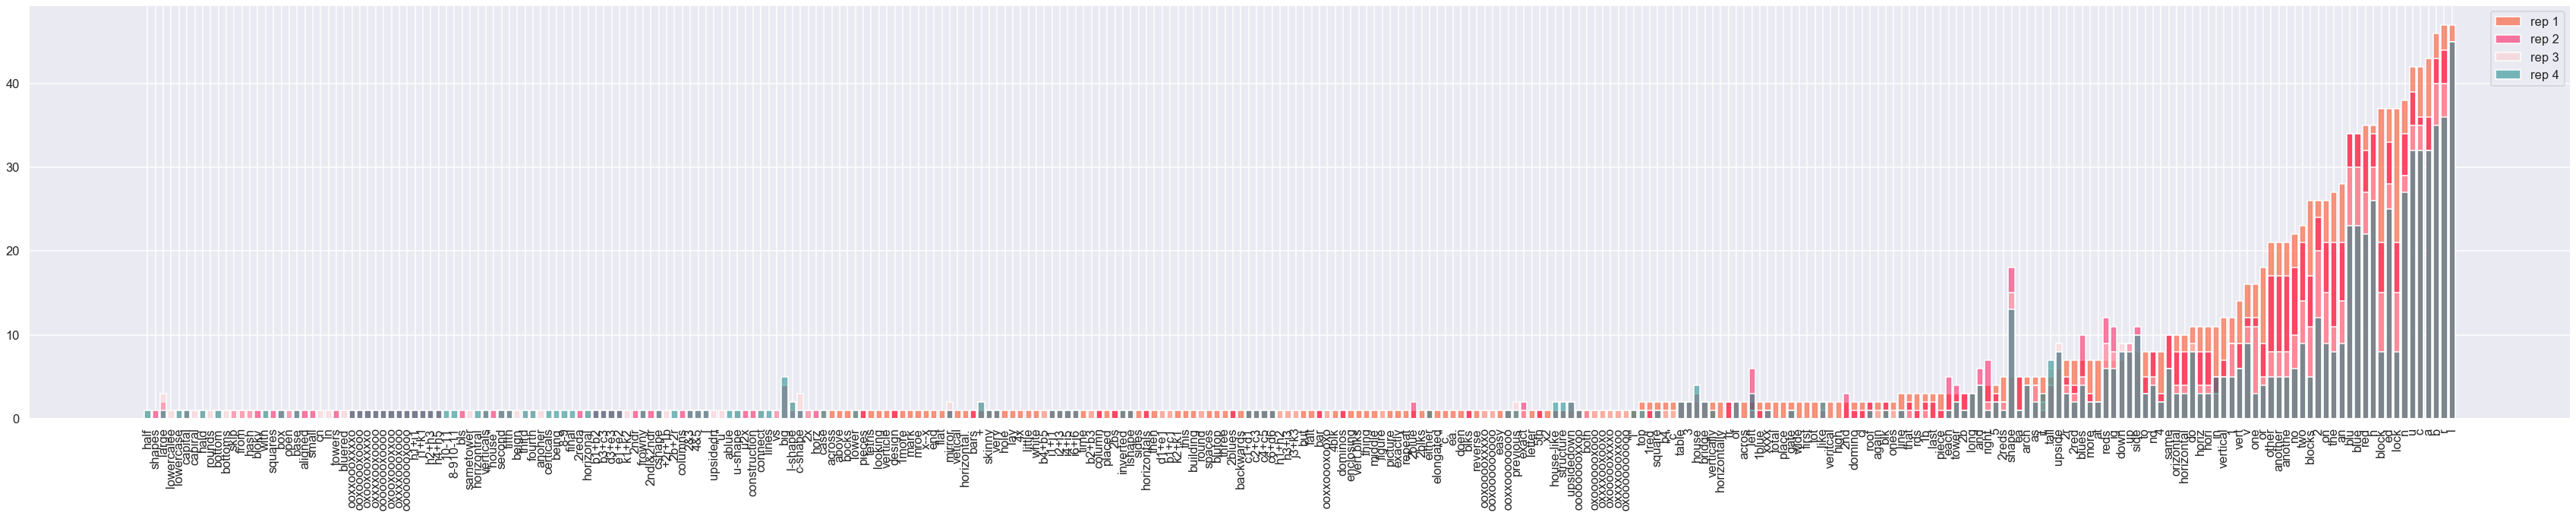

In [549]:
fig = plt.figure(figsize=(60,10))
ax = fig.add_subplot(111)
ax.bar(x = df_all_words_reps.columns, height= df_all_words_reps.loc[0,:], fc=(1, 0.2, 0, 0.5))
ax.bar(x = df_all_words_reps.columns, height= df_all_words_reps.loc[1,:], fc=(1, 0, 0.3, 0.5))
ax.bar(x = df_all_words_reps.columns, height= df_all_words_reps.loc[2,:], fc=(1, 0.8, 0.8, 0.5))
ax.bar(x = df_all_words_reps.columns, height= df_all_words_reps.loc[3,:], fc=(0, 0.5, 0.5, 0.5))
plt.legend(['rep 1', 'rep 2', 'rep 3', 'rep 4'])
_ = plt.xticks(rotation='vertical')
#plt.savefig('words_by_dyads.pdf')

In [542]:
df_all_words_reps.columns

Index(['two', 'blue', 'blocks', 'red', 'block', 'one', 'same', 'exact',
       'construction', 'the',
       ...
       'fifth', 'lock', 'beign', 'third', 'fourth', 'anoher', 'certicals',
       'being', 'squares', 'ablue'],
      dtype='object', length=294)